In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import pandas as pd
import numpy as np
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gradio as gr
from google.colab import drive


warnings.simplefilter("ignore", category=Warning)


chemin = '/content/drive/MyDrive/perfume_database_cleaned.xlsx'


df = pd.read_excel(chemin, usecols=['brand', 'perfume', 'notes'])


In [41]:
df

,brand,perfume,notes
0,18 21 Man Made,Sweet Tobacco Spirits,"citruses, saffron, tonka bean, vanilla, exotic..."
1,40 Notes Perfume,Cashmere Musk,"sandalwood, cedar, white musk, cashmere wood"
2,40 Notes Perfume,Exotic Ylang Ylang,"ylang-ylang, gardenia, musk"
3,40 Notes Perfume,Exquisite Amber,"labdanum, styrax, benzoin, vanilla, musk"
4,40 Notes Perfume,Oudwood Veil,"kephalis, agarwood (oud)"
...,...,...,...
36964,Urban Rituelle,Lemongrass Blend,"lemongrass, myrtle, grapefruit, eucalyptus"
36965,Urban Rituelle,Peach Blossom,"peach, honey, sweet pea, mimosa"
36966,Urban Rituelle,Pomegranate,"pomegranate, citruses, red berries"
36967,Urban Rituelle,Vanilla,"vanilla, caramel, milk"


In [42]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36969 entries, 0 to 36968
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   brand    36969 non-null  object
 1   perfume  36966 non-null  object
 2   notes    36969 non-null  object
dtypes: object(3)
memory usage: 866.6+ KB


In [43]:
df.describe()

,brand,perfume,notes
count,36969,36966,36969
unique,2536,33157,35333
top,Avon,Patchouli,floral notes
freq,628,39,66


In [44]:
df.isna().sum()

,0
brand,0
perfume,3
notes,0


In [45]:
parfums_manquants = df[df['perfume'].isna()]


parfums_manquants


,brand,perfume,notes
3084,D S Durga,NaN,"musk, tuberose, styrax, tonka bean, leather"
4941,Haught Parfums,NaN,"gardenia, tuberose, magnolia, mint, sandalwood..."
32951,Faberlic,NaN,"caramel, vanilla, violet, mimosa, jasmine, lil..."


In [46]:
# Supprimer les lignes où la colonne 'perfume' a des valeurs manquantes
df = df[df['perfume'].notna()]

# Réinitialiser les index après suppression des lignes
df.reset_index(drop=True, inplace=True)

df


,brand,perfume,notes
0,18 21 Man Made,Sweet Tobacco Spirits,"citruses, saffron, tonka bean, vanilla, exotic..."
1,40 Notes Perfume,Cashmere Musk,"sandalwood, cedar, white musk, cashmere wood"
2,40 Notes Perfume,Exotic Ylang Ylang,"ylang-ylang, gardenia, musk"
3,40 Notes Perfume,Exquisite Amber,"labdanum, styrax, benzoin, vanilla, musk"
4,40 Notes Perfume,Oudwood Veil,"kephalis, agarwood (oud)"
...,...,...,...
36961,Urban Rituelle,Lemongrass Blend,"lemongrass, myrtle, grapefruit, eucalyptus"
36962,Urban Rituelle,Peach Blossom,"peach, honey, sweet pea, mimosa"
36963,Urban Rituelle,Pomegranate,"pomegranate, citruses, red berries"
36964,Urban Rituelle,Vanilla,"vanilla, caramel, milk"


In [47]:
# Distribution des marques
df['brand'].value_counts()


,count
brand,
Avon,628
Demeter Fragrance,328
Guerlain,327
Victoria s Secret,287
O Boticario,240
...,...
Barbara Orbison,1
Barberry Coast Shave Co,1
Baywatch,1


In [48]:

from collections import Counter

df['notes_split'] = df['notes'].apply(lambda x: x.split(','))


note_counter = Counter([note.strip() for sublist in df['notes_split'] for note in sublist])

# Afficher les notes les plus fréquentes
notes_df = pd.DataFrame(note_counter.items(), columns=['Note', 'Fréquence']).sort_values(by='Fréquence', ascending=False)
notes_df


,Note,Fréquence
6,musk,15056
20,jasmine,11155
8,sandalwood,10755
67,bergamot,10529
38,amber,10485
...,...,...
1260,black pomegranate,1
1262,madeira,1
1264,fresh almond,1
1267,satureja,1


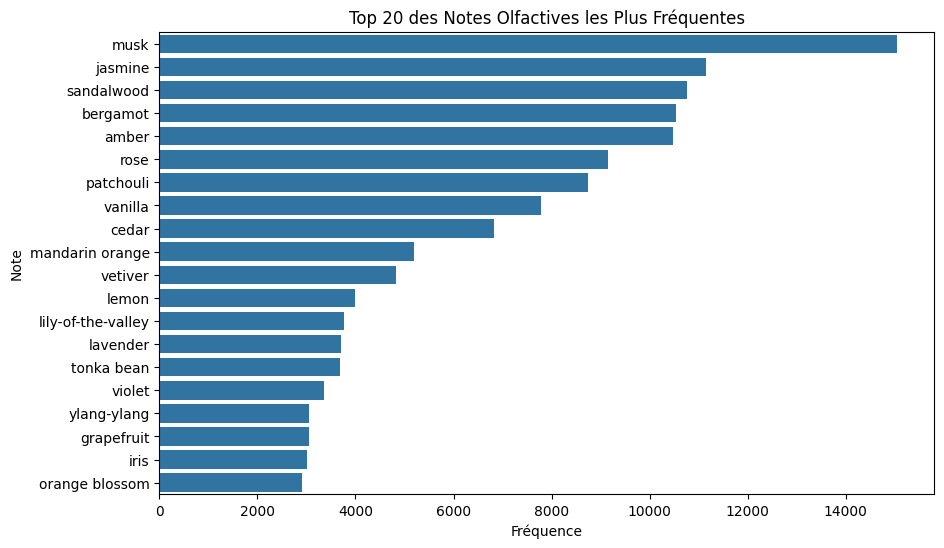

In [49]:
# Visualiser les notes les plus fréquentes
plt.figure(figsize=(10,6))
sns.barplot(x='Fréquence', y='Note', data=notes_df.head(20))
plt.title("Top 20 des Notes Olfactives les Plus Fréquentes")
plt.show()


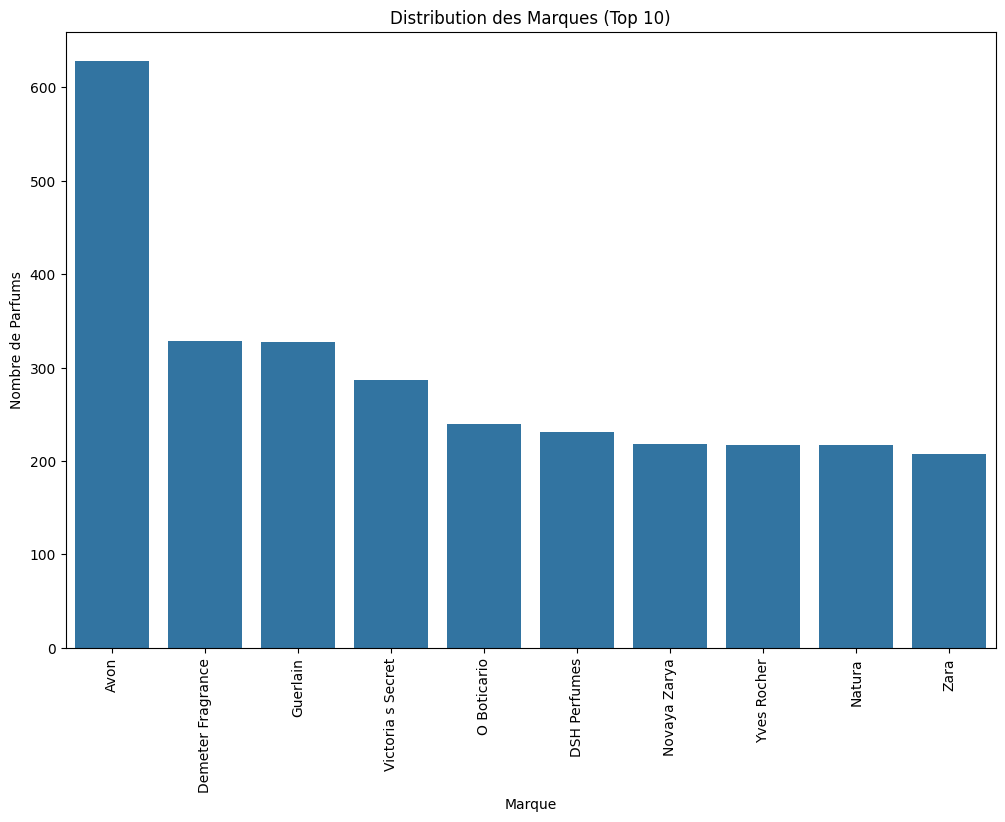

In [50]:
brand_count = df['brand'].value_counts()

# 2. Visualiser la distribution des marques (Top 10 marques)
plt.figure(figsize=(12,8))
sns.barplot(x=brand_count.head(10).index, y=brand_count.head(10).values)
plt.title("Distribution des Marques (Top 10)")
plt.ylabel("Nombre de Parfums")
plt.xlabel("Marque")
plt.xticks(rotation=90)
plt.show()


# Calcul de la Similarité Cosinus avec TF-IDF

In [51]:
# Vectorisation des notes olfactives avec TF-IDF
def tokenizer_personnalise(texte):
    return [note.strip() for note in texte.split(',')]

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenizer_personnalise)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['notes'])

# Calcul de la similarité cosinus avec TF-IDF
matrice_similarite_tfidf = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Liste unique des notes disponibles
notes_uniques = sorted(set([note.strip() for sous_liste in df['notes'].str.split(',') for note in sous_liste]))
parfums_uniques = sorted(df['perfume'].dropna().astype(str).unique())


# Fonction de recommendation par notes olfactives

In [52]:
def recommander_par_notes(notes_utilisateur, top_n=5):
    if not notes_utilisateur:
        return pd.DataFrame(columns=["Marque", "Parfum", "Similarité", "Notes"])

    notes_utilisateur_str = ', '.join(notes_utilisateur).lower()
    vecteur_utilisateur = tfidf_vectorizer.transform([notes_utilisateur_str])
    scores_similarite = cosine_similarity(vecteur_utilisateur, tfidf_matrix).flatten()
    indices_top = scores_similarite.argsort()[-top_n:][::-1]
    recommandations = df.iloc[indices_top].copy()
    recommandations['similarity'] = scores_similarite[indices_top]
    recommandations['similarity'] = recommandations['similarity'].map("{:.2%}".format)

    
    recommandations = recommandations.rename(columns={
        'brand': 'Marque',
        'perfume': 'Parfum',
        'similarity': 'Similarité',
        'notes': 'Notes'
    })

    return recommandations[['Marque', 'Parfum', 'Similarité', 'Notes']]

# Fonction de recommandation par nom de parfum

In [53]:
def recommander_par_nom(nom_parfum, top_n=5):
    if not nom_parfum:
        return pd.DataFrame(columns=["Marque", "Parfum", "Similarité", "Notes"])

    # Trouver l'index du parfum saisi
    try:
        idx = df[df['perfume'].astype(str).str.lower() == nom_parfum.lower()].index[0]
    except IndexError:
        return pd.DataFrame(columns=["Marque", "Parfum", "Similarité", "Notes"])

    scores_similarite = matrice_similarite_tfidf[idx]
    indices_top = scores_similarite.argsort()[-(top_n+1):][::-1]  # +1 car le parfum lui-même est inclus
    indices_top = indices_top[indices_top != idx]  # Exclure le parfum lui-même
    recommandations = df.iloc[indices_top].copy()
    recommandations['similarity'] = scores_similarite[indices_top]
    recommandations['similarity'] = recommandations['similarity'].map("{:.2%}".format)

    
    recommandations = recommandations.rename(columns={
        'brand': 'Marque',
        'perfume': 'Parfum',
        'similarity': 'Similarité',
        'notes': 'Notes'
    })

    return recommandations[['Marque', 'Parfum', 'Similarité', 'Notes']]

# Interface Utilisateur

In [54]:
def afficher_options_recherche():
    return gr.update(visible=False), gr.update(visible=True)

def afficher_saisie_notes():
    return gr.update(visible=True), gr.update(visible=False), gr.update(visible=False), gr.update(visible=False)

def afficher_saisie_nom():
    return gr.update(visible=False), gr.update(visible=True), gr.update(visible=False), gr.update(visible=False)

def retour_aux_options_depuis_notes():
    return gr.update(visible=False), gr.update(visible=True), gr.update(visible=False), gr.update(visible=False)

def retour_aux_options_depuis_nom():
    return gr.update(visible=False), gr.update(visible=True), gr.update(visible=False), gr.update(visible=False)


with gr.Blocks() as demo:
    gr.Markdown(
    """
    # Système de Recommandation de Parfums
    Choisissez votre méthode de recherche préférée.
    """
    )

    # Bouton initial pour afficher les options de recherche
    bouton_demarrer = gr.Button("Commencer la recherche")

    with gr.Row(visible=False) as boutons_options:
        bouton_recherche_notes = gr.Button("Recherche par Notes")
        bouton_recherche_nom = gr.Button("Recherche par Nom de Parfum")

    with gr.Column(visible=False) as recherche_par_notes:
        saisie_notes = gr.CheckboxGroup(
            choices=notes_uniques,
            label="Sélectionnez les notes que vous aimez",
            info="Choisissez une ou plusieurs notes olfactives."
        )
        saisie_top_n_notes = gr.Slider(
            minimum=1,
            maximum=20,
            step=1,
            value=5,
            label="Nombre de recommandations"
        )
        bouton_recommander_notes = gr.Button("Recommander par Notes")
        bouton_retour_notes = gr.Button("Retour")

    with gr.Column(visible=False) as recherche_par_nom:
        saisie_nom_parfum = gr.Dropdown(
            choices=parfums_uniques,
            label="Sélectionnez le parfum que vous aimez",
            info="Choisissez un parfum dans la liste."
        )
        saisie_top_n_nom = gr.Slider(
            minimum=1,
            maximum=20,
            step=1,
            value=5,
            label="Nombre de recommandations"
        )
        bouton_recommander_nom = gr.Button("Recommander par Nom de Parfum")
        bouton_retour_nom = gr.Button("Retour")

    with gr.Column(visible=False) as section_resultats:
        tableau_resultats = gr.Dataframe(
            headers=["Marque", "Parfum", "Similarité", "Notes"],
            label="Parfums Recommandés",
            interactive=False
        )

    
    bouton_demarrer.click(
        afficher_options_recherche,
        inputs=None,
        outputs=[bouton_demarrer, boutons_options]
    )

    bouton_recherche_notes.click(
        afficher_saisie_notes,
        inputs=None,
        outputs=[recherche_par_notes, recherche_par_nom, boutons_options, section_resultats]
    )

    bouton_recherche_nom.click(
        afficher_saisie_nom,
        inputs=None,
        outputs=[recherche_par_notes, recherche_par_nom, boutons_options, section_resultats]
    )

    bouton_recommander_notes.click(
        fn=recommander_par_notes,
        inputs=[saisie_notes, saisie_top_n_notes],
        outputs=[tableau_resultats]
    )
    bouton_recommander_notes.click(
        lambda: gr.update(visible=True),
        inputs=None,
        outputs=[section_resultats]
    )

    bouton_recommander_nom.click(
        fn=recommander_par_nom,
        inputs=[saisie_nom_parfum, saisie_top_n_nom],
        outputs=[tableau_resultats]
    )
    bouton_recommander_nom.click(
        lambda: gr.update(visible=True),
        inputs=None,
        outputs=[section_resultats]
    )

    
    bouton_retour_notes.click(
        retour_aux_options_depuis_notes,
        inputs=None,
        outputs=[recherche_par_notes, boutons_options, section_resultats, section_resultats]
    )

    bouton_retour_nom.click(
        retour_aux_options_depuis_nom,
        inputs=None,
        outputs=[recherche_par_nom, boutons_options, section_resultats, section_resultats]
    )

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5ef143bc0fad78237a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
